## Importing Required Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import warnings
warnings.filterwarnings('ignore')

from sklearn.preprocessing import LabelEncoder,MinMaxScaler
from sklearn.model_selection import train_test_split


import string
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.multioutput import MultiOutputClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier


from sklearn.metrics import accuracy_score,confusion_matrix,classification_report
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import GridSearchCV

In [2]:
data=pd.read_csv('/content/drugsCom_raw.tsv',sep='\t',on_bad_lines="warn",engine="python")

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 161297 entries, 0 to 161296
Data columns (total 7 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   Unnamed: 0   161297 non-null  int64  
 1   drugName     161297 non-null  object 
 2   condition    160398 non-null  object 
 3   review       161297 non-null  object 
 4   rating       161297 non-null  float64
 5   date         161297 non-null  object 
 6   usefulCount  161297 non-null  int64  
dtypes: float64(1), int64(2), object(4)
memory usage: 8.6+ MB


In [4]:
data.head(10)

,Unnamed: 0,drugName,condition,review,rating,date,usefulCount
0,206461,Valsartan,Left Ventricular Dysfunction,"""It has no side effect, I take it in combinati...",9.0,"May 20, 2012",27
1,95260,Guanfacine,ADHD,"""My son is halfway through his fourth week of ...",8.0,"April 27, 2010",192
2,92703,Lybrel,Birth Control,"""I used to take another oral contraceptive, wh...",5.0,"December 14, 2009",17
3,138000,Ortho Evra,Birth Control,"""This is my first time using any form of birth...",8.0,"November 3, 2015",10
4,35696,Buprenorphine / naloxone,Opiate Dependence,"""Suboxone has completely turned my life around...",9.0,"November 27, 2016",37
5,155963,Cialis,Benign Prostatic Hyperplasia,"""2nd day on 5mg started to work with rock hard...",2.0,"November 28, 2015",43
6,165907,Levonorgestrel,Emergency Contraception,"""He pulled out, but he cummed a bit in me. I t...",1.0,"March 7, 2017",5
7,102654,Aripiprazole,Bipolar Disorde,"""Abilify changed my life. There is hope. I was...",10.0,"March 14, 2015",32
8,74811,Keppra,Epilepsy,""" I Ve had nothing but problems with the Kepp...",1.0,"August 9, 2016",11
9,48928,Ethinyl estradiol / levonorgestrel,Birth Control,"""I had been on the pill for many years. When m...",8.0,"December 8, 2016",1


In [5]:
data["condition"].unique()

array(['Left Ventricular Dysfunction', 'ADHD', 'Birth Control',
       'Opiate Dependence', 'Benign Prostatic Hyperplasia',
       'Emergency Contraception', 'Bipolar Disorde', 'Epilepsy',
       'Migraine Prevention', 'Depression', "Crohn's Disease", 'Cough',
       'Obesity', 'Urinary Tract Infection', 'ibromyalgia',
       'Chronic Myelogenous Leukemia', 'HIV Infection', 'Insomnia',
       'Rheumatoid Arthritis', 'Vaginal Yeast Infection',
       'Chlamydia Infection', 'Hirsutism', 'Panic Disorde', 'Migraine',
       nan, 'Pain', 'Irritable Bowel Syndrome', 'Osteoarthritis',
       'Constipation', 'Bowel Preparation', 'Psychosis', 'Muscle Spasm',
       'Hepatitis C', 'Overactive Bladde', 'Diabetes, Type 2',
       'Asthma, Maintenance', 'Non-Small Cell Lung Cance',
       'Schizophrenia', 'Dysuria', 'Smoking Cessation', 'Anxiety', 'Acne',
       'emale Infertility', 'Constipation, Acute',
       'Constipation, Drug Induced', 'Erectile Dysfunction',
       'Trigeminal Neuralgia', 'U

In [6]:
len(data["condition"].unique())

885

In [7]:
data["condition"].value_counts()

,count
condition,
Birth Control,28788
Depression,9069
Pain,6145
Anxiety,5904
Acne,5588
...,...
Dissociative Identity Disorde,1
Hydrocephalus,1
"Hyperlipoproteinemia Type III, Elevated beta-VLDL IDL",1


In [8]:
main_data=data[(data['condition']=="Depression") | (data['condition']=="High Blood Pressure") | (data['condition']=="Diabetes, Type 2")]

In [9]:
main_data.reset_index(drop=True,inplace=True)

In [10]:
main_data.head()

,Unnamed: 0,drugName,condition,review,rating,date,usefulCount
0,75612,L-methylfolate,Depression,"""I have taken anti-depressants for years, with...",10.0,"March 9, 2017",54
1,96233,Sertraline,Depression,"""1 week on Zoloft for anxiety and mood swings....",8.0,"May 7, 2011",3
2,121333,Venlafaxine,Depression,"""my gp started me on Venlafaxine yesterday to ...",4.0,"April 27, 2016",3
3,156544,Dulaglutide,"Diabetes, Type 2","""Hey Guys, It&#039;s been 4 months since my l...",10.0,"October 24, 2017",24
4,131909,Effexor XR,Depression,"""This medicine saved my life. I was at my wits...",10.0,"June 20, 2013",166


In [11]:
main_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13944 entries, 0 to 13943
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Unnamed: 0   13944 non-null  int64  
 1   drugName     13944 non-null  object 
 2   condition    13944 non-null  object 
 3   review       13944 non-null  object 
 4   rating       13944 non-null  float64
 5   date         13944 non-null  object 
 6   usefulCount  13944 non-null  int64  
dtypes: float64(1), int64(2), object(4)
memory usage: 762.7+ KB


In [12]:
len(main_data["drugName"].unique())

334

In [13]:
main_data["drugName"].value_counts()

,count
drugName,
Bupropion,549
Sertraline,459
Venlafaxine,437
Pristiq,418
Desvenlafaxine,414
...,...
Insulin aspart / insulin aspart protamine,1
Tarka,1
Exforge HCT,1


In [14]:
 main_data.isnull().sum()

,0
Unnamed: 0,0
drugName,0
condition,0
review,0
rating,0
date,0
usefulCount,0


In [15]:
main_data[main_data.duplicated(keep=False)]

,Unnamed: 0,drugName,condition,review,rating,date,usefulCount


In [16]:
main_data.drop_duplicates(keep="first",inplace=True)

In [17]:
main_data.reset_index(drop=True,inplace=True)

In [18]:
main_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13944 entries, 0 to 13943
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Unnamed: 0   13944 non-null  int64  
 1   drugName     13944 non-null  object 
 2   condition    13944 non-null  object 
 3   review       13944 non-null  object 
 4   rating       13944 non-null  float64
 5   date         13944 non-null  object 
 6   usefulCount  13944 non-null  int64  
dtypes: float64(1), int64(2), object(4)
memory usage: 762.7+ KB


In [19]:
main_data.drop(["Unnamed: 0","date"],axis=1,inplace=True)

In [20]:
main_data

,drugName,condition,review,rating,usefulCount
0,L-methylfolate,Depression,"""I have taken anti-depressants for years, with...",10.0,54
1,Sertraline,Depression,"""1 week on Zoloft for anxiety and mood swings....",8.0,3
2,Venlafaxine,Depression,"""my gp started me on Venlafaxine yesterday to ...",4.0,3
3,Dulaglutide,"Diabetes, Type 2","""Hey Guys, It&#039;s been 4 months since my l...",10.0,24
4,Effexor XR,Depression,"""This medicine saved my life. I was at my wits...",10.0,166
...,...,...,...,...,...
13939,Metoprolol,High Blood Pressure,"""It is fourth blood pressure pill for me. It f...",4.0,39
13940,Bystolic,High Blood Pressure,"""While on Bystolic my feet and arms were numb....",1.0,25
13941,Invokana,"Diabetes, Type 2","""I just got diagnosed with type 2. My doctor p...",9.0,47
13942,Vortioxetine,Depression,"""This is the third med I&#039;ve tried for anx...",2.0,33


# Visualizations

<Axes: ylabel='count'>

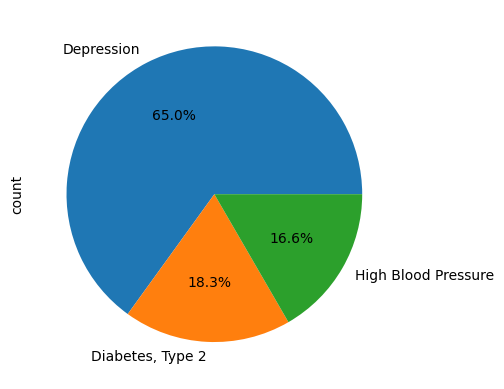

In [21]:
main_data["condition"].value_counts().plot(kind="pie",autopct="%1.1f%%")

<Axes: ylabel='count'>

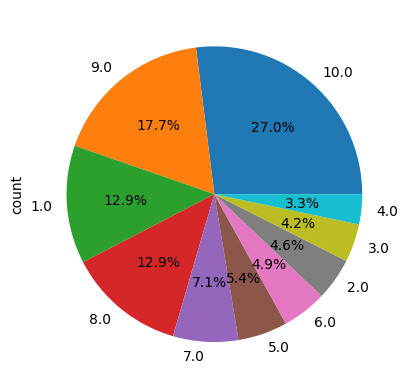

In [22]:
main_data["rating"].value_counts().plot(kind="pie",autopct="%1.1f%%")

### Detecting and Treating Anamolies

{'whiskers': [<matplotlib.lines.Line2D at 0x7b388aea2f20>,
 'caps': [<matplotlib.lines.Line2D at 0x7b388aea3460>,
 'boxes': [<matplotlib.lines.Line2D at 0x7b388aea2c80>],
 'medians': [<matplotlib.lines.Line2D at 0x7b388aea39a0>],
 'fliers': [<matplotlib.lines.Line2D at 0x7b388aea3c40>],
 'means': []}

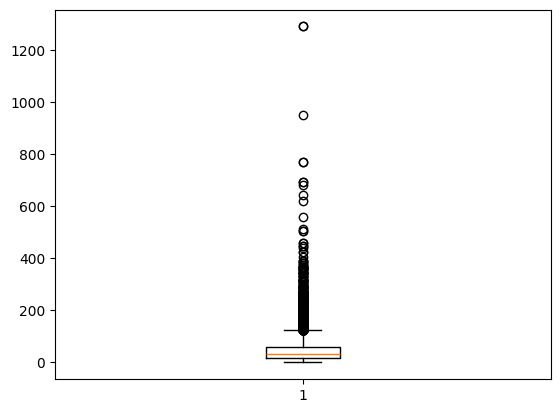

In [23]:
plt.boxplot(main_data["usefulCount"])

In [24]:
main_data["usefulCount"].describe()

,usefulCount
count,13944.000000
mean,45.737880
std,51.782627
min,0.000000
25%,16.000000
50%,31.000000
75%,59.000000
max,1291.000000


In [25]:
a=np.percentile(main_data.usefulCount,[99][0])

In [26]:
main_data.usefulCount[(main_data.usefulCount>3*a)].count()

5

In [27]:
main_data.usefulCount[(main_data.usefulCount>3*a)]=3*a

<Axes: xlabel='rating', ylabel='usefulCount'>

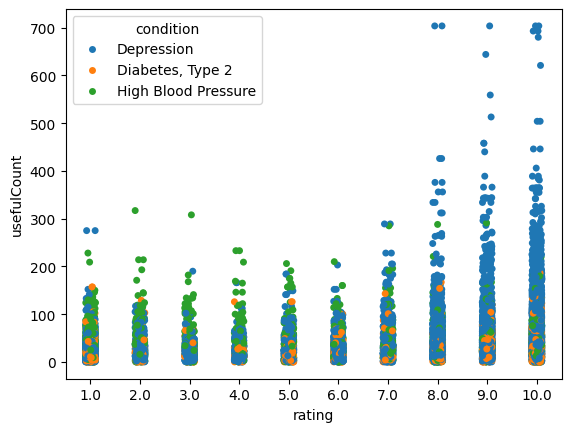

In [28]:
sns.stripplot(x="rating",y="usefulCount",data=main_data,hue="condition")

<Axes: xlabel='rating'>

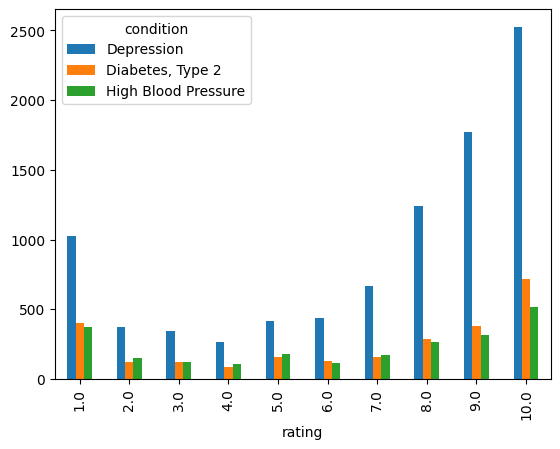

In [29]:
pd.crosstab(main_data.rating,main_data.condition).plot(kind="bar")

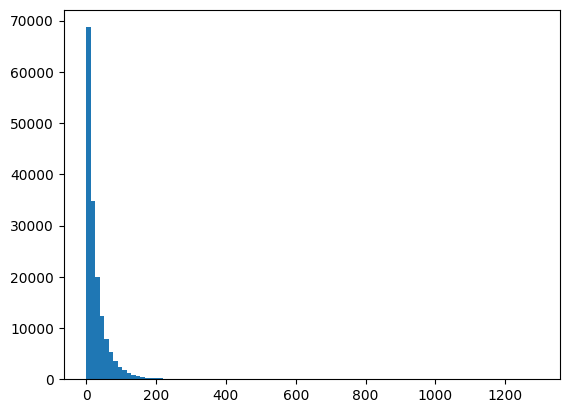

In [30]:
plt.hist(data["usefulCount"],bins=100)
plt.show()

### Normalization

In [31]:
scale=MinMaxScaler()
main_data["usefulCount"]=scale.fit_transform(main_data[["usefulCount"]])

In [32]:
main_data

,drugName,condition,review,rating,usefulCount
0,L-methylfolate,Depression,"""I have taken anti-depressants for years, with...",10.0,0.076736
1,Sertraline,Depression,"""1 week on Zoloft for anxiety and mood swings....",8.0,0.004263
2,Venlafaxine,Depression,"""my gp started me on Venlafaxine yesterday to ...",4.0,0.004263
3,Dulaglutide,"Diabetes, Type 2","""Hey Guys, It&#039;s been 4 months since my l...",10.0,0.034105
4,Effexor XR,Depression,"""This medicine saved my life. I was at my wits...",10.0,0.235893
...,...,...,...,...,...
13939,Metoprolol,High Blood Pressure,"""It is fourth blood pressure pill for me. It f...",4.0,0.055421
13940,Bystolic,High Blood Pressure,"""While on Bystolic my feet and arms were numb....",1.0,0.035526
13941,Invokana,"Diabetes, Type 2","""I just got diagnosed with type 2. My doctor p...",9.0,0.066789
13942,Vortioxetine,Depression,"""This is the third med I&#039;ve tried for anx...",2.0,0.046894


### Encoding

In [33]:
encode=pd.get_dummies(main_data["condition"],dtype=int)

In [34]:
main_data=pd.concat([main_data,encode],axis=1)

In [35]:
main_data.drop(["condition"],axis=1,inplace=True)

In [36]:
encoder=LabelEncoder()
main_data["drugName"]=encoder.fit_transform(main_data["drugName"])

In [37]:
main_data

,drugName,review,rating,usefulCount,Depression,"Diabetes, Type 2",High Blood Pressure
0,173,"""I have taken anti-depressants for years, with...",10.0,0.076736,1,0,0
1,275,"""1 week on Zoloft for anxiety and mood swings....",8.0,0.004263,1,0,0
2,313,"""my gp started me on Venlafaxine yesterday to ...",4.0,0.004263,1,0,0
3,89,"""Hey Guys, It&#039;s been 4 months since my l...",10.0,0.034105,0,1,0
4,95,"""This medicine saved my life. I was at my wits...",10.0,0.235893,1,0,0
...,...,...,...,...,...,...,...
13939,202,"""It is fourth blood pressure pill for me. It f...",4.0,0.055421,0,0,1
13940,55,"""While on Bystolic my feet and arms were numb....",1.0,0.035526,0,0,1
13941,164,"""I just got diagnosed with type 2. My doctor p...",9.0,0.066789,0,1,0
13942,320,"""This is the third med I&#039;ve tried for anx...",2.0,0.046894,1,0,0


### Preprocessing the NLP part

In [38]:
import nltk
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [39]:
def clean_text(text):

    text = text.translate(str.maketrans(''""'', '', string.punctuation))

    text = text.lower()

    tokens = word_tokenize(text)

    tokens = [word for word in tokens if word not in stopwords.words('english')]

    lemmer=WordNetLemmatizer()
    tokens=[lemmer.lemmatize(word) for word in tokens]

    return ' '.join(tokens)

In [40]:
main_data['Cleaned_review'] = main_data['review'].apply(clean_text)

In [42]:
unigrams = word_tokenize(str(main_data['Cleaned_review']))
print(unigrams)

['0', 'taken', 'antidepressant', 'year', 'improvement', 'mostly', 'm', '...', '1', '1', 'week', 'zoloft', 'anxiety', 'mood', 'swing', 'take', '50mg', 'mor', '...', '2', 'gp', 'started', 'venlafaxine', 'yesterday', 'help', 'depressi', '...', '3', 'hey', 'guy', 'it039s', '4', 'month', 'since', 'last', 'post', 'wanted', '...', '4', 'medicine', 'saved', 'life', 'wit', 'end', 'antidepressant', 'rea', '...', '...', '13939', 'fourth', 'blood', 'pressure', 'pill', 'feel', 'like', 'partly', 'wo', '...', '13940', 'bystolic', 'foot', 'arm', 'numb', 'blood', 'sugar', 'became', 'seve', '...', '13941', 'got', 'diagnosed', 'type', '2', 'doctor', 'prescribed', 'invokan', '...', '13942', 'third', 'med', 'i039ve', 'tried', 'anxiety', 'mild', 'depression', '...', '13943', 'tekturna', '9', 'day', 'effect', 'immediate', 'also', 'calcium', 'c', '...', 'Name', ':', 'Cleaned_review', ',', 'Length', ':', '13944', ',', 'dtype', ':', 'object']


# Unigram Plot

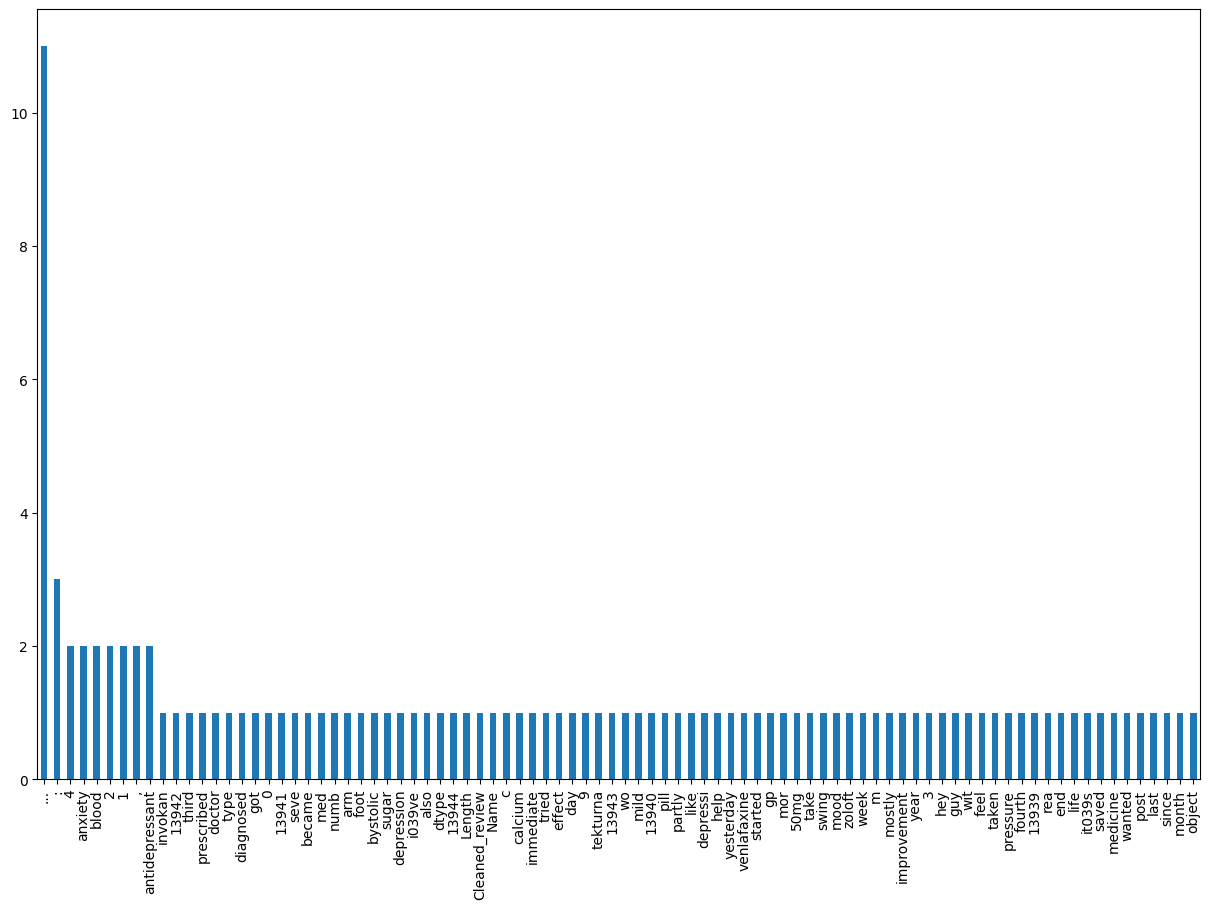

In [43]:
unigrams_series = pd.Series(unigrams).value_counts()
unigrams_series.plot(kind="bar",figsize=(15,10))
plt.show()

In [44]:
unigrams_array = np.array(unigrams)
print(unigrams_array.shape)

(107,)


In [45]:
from nltk import bigrams
from nltk.tokenize import word_tokenize
from collections import Counter
# Tokenize the text and generate bigrams
tokens = word_tokenize(str(main_data['Cleaned_review']))
bigram_list = list(bigrams(tokens))
Counter(bigram_list)

Counter({('0', 'taken'): 1,
         ('taken', 'antidepressant'): 1,
         ('antidepressant', 'year'): 1,
         ('year', 'improvement'): 1,
         ('improvement', 'mostly'): 1,
         ('mostly', 'm'): 1,
         ('m', '...'): 1,
         ('...', '1'): 1,
         ('1', '1'): 1,
         ('1', 'week'): 1,
         ('week', 'zoloft'): 1,
         ('zoloft', 'anxiety'): 1,
         ('anxiety', 'mood'): 1,
         ('mood', 'swing'): 1,
         ('swing', 'take'): 1,
         ('take', '50mg'): 1,
         ('50mg', 'mor'): 1,
         ('mor', '...'): 1,
         ('...', '2'): 1,
         ('2', 'gp'): 1,
         ('gp', 'started'): 1,
         ('started', 'venlafaxine'): 1,
         ('venlafaxine', 'yesterday'): 1,
         ('yesterday', 'help'): 1,
         ('help', 'depressi'): 1,
         ('depressi', '...'): 1,
         ('...', '3'): 1,
         ('3', 'hey'): 1,
         ('hey', 'guy'): 1,
         ('guy', 'it039s'): 1,
         ('it039s', '4'): 1,
         ('4', 'month'): 1,


In [46]:
bigram_array = np.array(bigram_list)
print(bigram_array.shape)

(106, 2)


# Bigram Plot

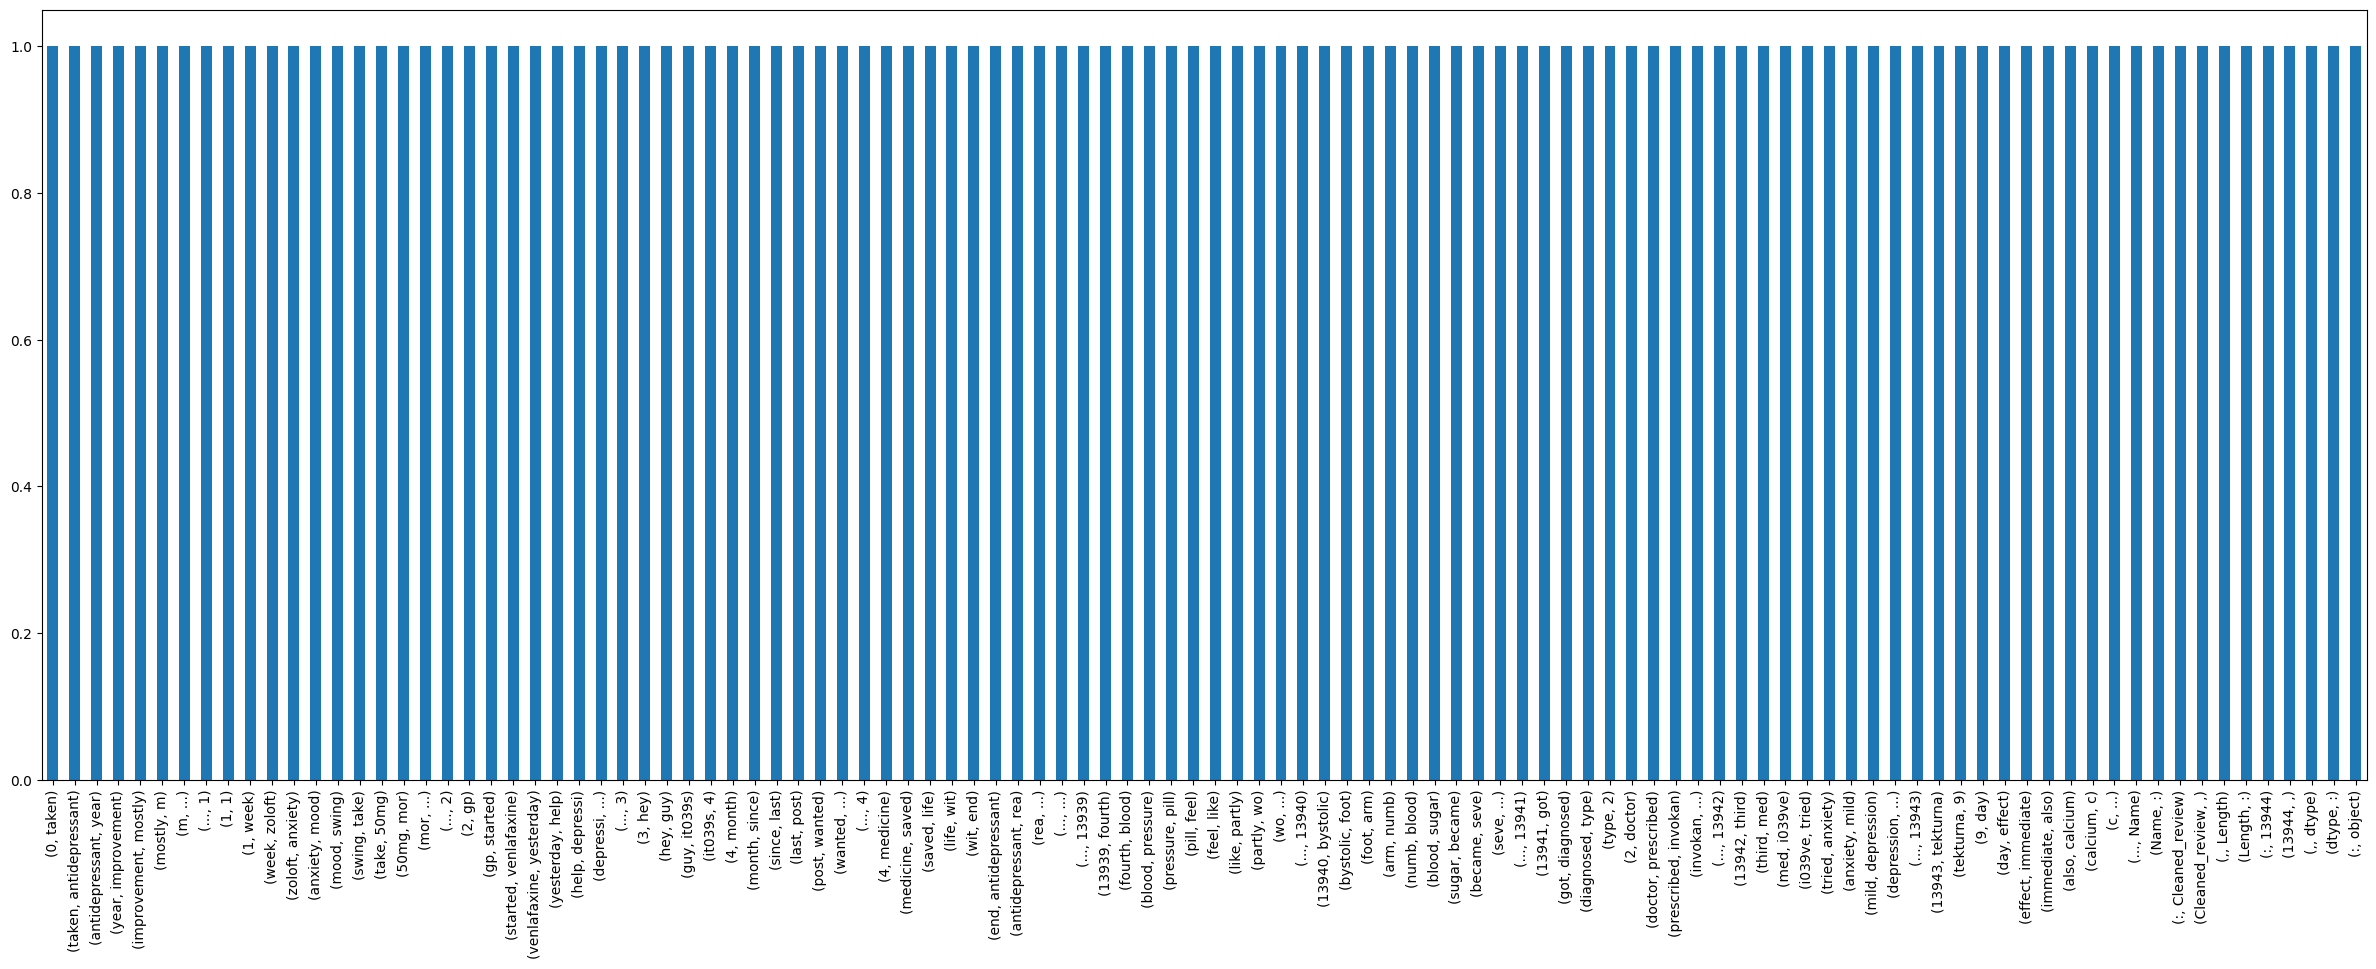

In [47]:
bigram_counts = Counter(bigram_list)
bigram_series= pd.Series(bigram_counts)
bigram_series.plot(kind="bar",figsize=(30,10))
plt.show()

In [48]:
from nltk import trigrams
tokens = word_tokenize(str(main_data['Cleaned_review']))
trigram_list = list(trigrams(tokens))
trigram_counts = Counter(trigram_list)
print(trigram_counts)

Counter({('0', 'taken', 'antidepressant'): 1, ('taken', 'antidepressant', 'year'): 1, ('antidepressant', 'year', 'improvement'): 1, ('year', 'improvement', 'mostly'): 1, ('improvement', 'mostly', 'm'): 1, ('mostly', 'm', '...'): 1, ('m', '...', '1'): 1, ('...', '1', '1'): 1, ('1', '1', 'week'): 1, ('1', 'week', 'zoloft'): 1, ('week', 'zoloft', 'anxiety'): 1, ('zoloft', 'anxiety', 'mood'): 1, ('anxiety', 'mood', 'swing'): 1, ('mood', 'swing', 'take'): 1, ('swing', 'take', '50mg'): 1, ('take', '50mg', 'mor'): 1, ('50mg', 'mor', '...'): 1, ('mor', '...', '2'): 1, ('...', '2', 'gp'): 1, ('2', 'gp', 'started'): 1, ('gp', 'started', 'venlafaxine'): 1, ('started', 'venlafaxine', 'yesterday'): 1, ('venlafaxine', 'yesterday', 'help'): 1, ('yesterday', 'help', 'depressi'): 1, ('help', 'depressi', '...'): 1, ('depressi', '...', '3'): 1, ('...', '3', 'hey'): 1, ('3', 'hey', 'guy'): 1, ('hey', 'guy', 'it039s'): 1, ('guy', 'it039s', '4'): 1, ('it039s', '4', 'month'): 1, ('4', 'month', 'since'): 1, (

In [49]:
trigrams_array = np.array(trigram_list)
print(trigrams_array.shape)

(105, 3)


# Trigram Plot

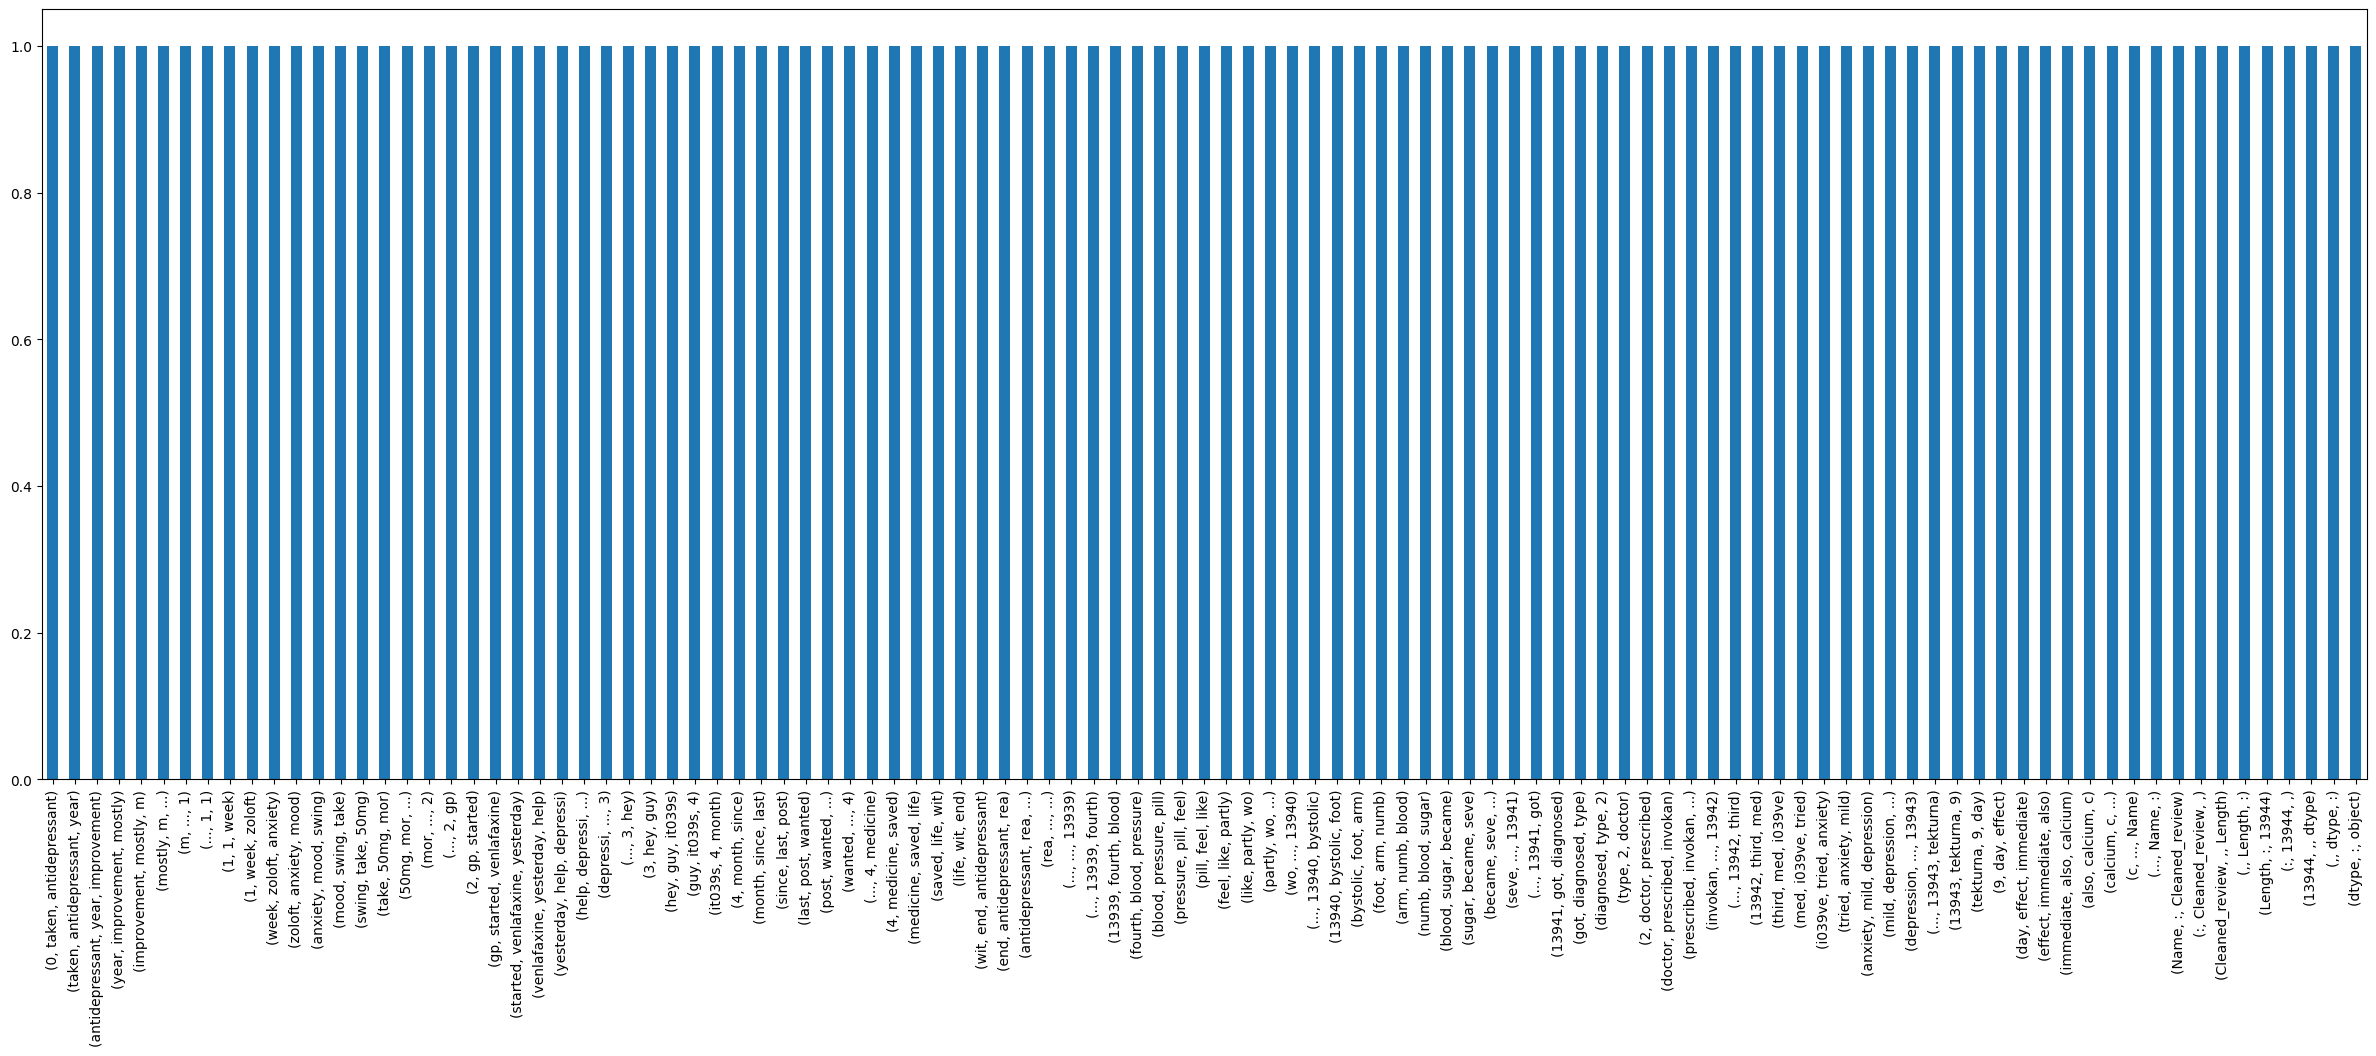

In [50]:
trigram_series= pd.Series(trigram_counts)
trigram_series.plot(kind="bar",figsize=(30,10))
plt.show()

## WordPlot

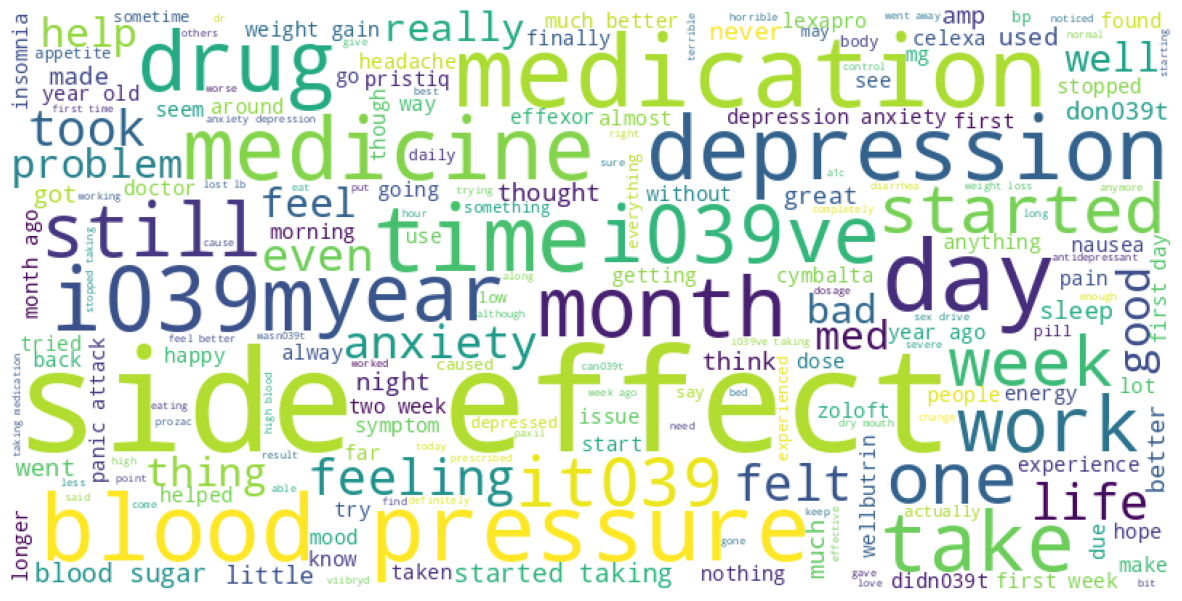

In [51]:
wordcloud=WordCloud(width=800,height=400,background_color="white").generate(" ".join(main_data["Cleaned_review"]))
plt.figure(figsize=(15,10))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

In [52]:
vectorizer = TfidfVectorizer(min_df=0.07, max_df=0.65)
tfidf_matrix = vectorizer.fit_transform(main_data['Cleaned_review'])


In [53]:
tfidf_matrix

<13944x92 sparse matrix of type '<class 'numpy.float64'>'
	with 181103 stored elements in Compressed Sparse Row format>

In [54]:
main_data=pd.concat([main_data,pd.DataFrame(tfidf_matrix.toarray())],axis=1)

In [55]:
main_data.drop(["review","Cleaned_review"],axis=1,inplace=True)

In [56]:
main_data

,drugName,rating,usefulCount,Depression,"Diabetes, Type 2",High Blood Pressure,0,1,2,3,...,82,83,84,85,86,87,88,89,90,91
0,173,10.0,0.076736,1,0,0,0.0,0.0,0.0,0.000000,...,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.169655
1,275,8.0,0.004263,1,0,0,0.0,0.0,0.0,0.000000,...,0.0,0.000000,0.390233,0.000000,0.0,0.273419,0.000000,0.0,0.000000,0.000000
2,313,4.0,0.004263,1,0,0,0.0,0.0,0.0,0.000000,...,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.152337,0.000000
3,89,10.0,0.034105,0,1,0,0.0,0.0,0.0,0.000000,...,0.0,0.177825,0.119033,0.321758,0.0,0.000000,0.148901,0.0,0.000000,0.000000
4,95,10.0,0.235893,1,0,0,0.0,0.0,0.0,0.189699,...,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.408948,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13939,202,4.0,0.055421,0,0,1,0.0,0.0,0.0,0.000000,...,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000
13940,55,1.0,0.035526,0,0,1,0.0,0.0,0.0,0.000000,...,0.0,0.000000,0.285538,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000
13941,164,9.0,0.066789,0,1,0,0.0,0.0,0.0,0.000000,...,0.0,0.000000,0.228881,0.309342,0.0,0.320734,0.000000,0.0,0.000000,0.000000
13942,320,2.0,0.046894,1,0,0,0.0,0.0,0.0,0.000000,...,0.0,0.000000,0.268562,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000


# Splitting data into Training and Testing set

In [57]:
X=main_data.drop(["Depression","Diabetes, Type 2","High Blood Pressure","usefulCount","rating","drugName"],axis=1)
Y=main_data[["Depression","Diabetes, Type 2","High Blood Pressure"]]

In [58]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=42)

# Model Building and Evaluation

# Random Forest

In [59]:
rf_model=RandomForestClassifier(n_estimators=100)

In [60]:
X_train.columns = X_train.columns.astype(str)
X_test.columns = X_test.columns.astype(str)

In [61]:
rf_model.fit(X_train,Y_train)

RandomForestClassifier()

In [62]:
Y_pred=rf_model.predict(X_test)
RF=accuracy_score(Y_test,Y_pred)*100
print("Accuracy Score ",RF)

Accuracy Score  86.78298279158699


In [63]:
print(classification_report(Y_test,Y_pred))

              precision    recall  f1-score   support

           0       0.91      0.95      0.93      2731
           1       0.95      0.74      0.83       746
           2       0.93      0.67      0.78       707

   micro avg       0.92      0.87      0.89      4184
   macro avg       0.93      0.79      0.85      4184
weighted avg       0.92      0.87      0.89      4184
 samples avg       0.87      0.87      0.87      4184



# Confusion Matrix


Confusion Matrices:

Confusion Matrix for Depression:
[[1189  264]
 [ 124 2607]]


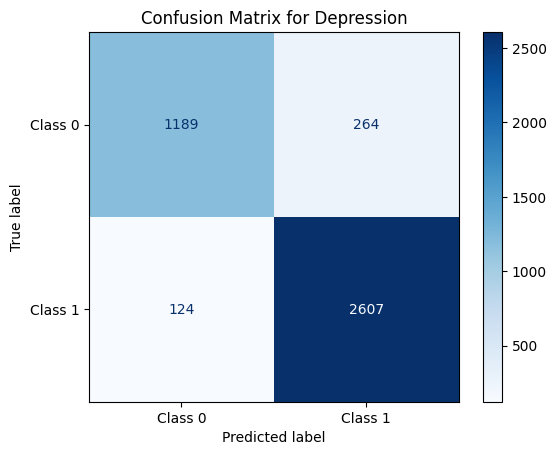


Confusion Matrix for Diabetes, Type 2:
[[3409   29]
 [ 194  552]]


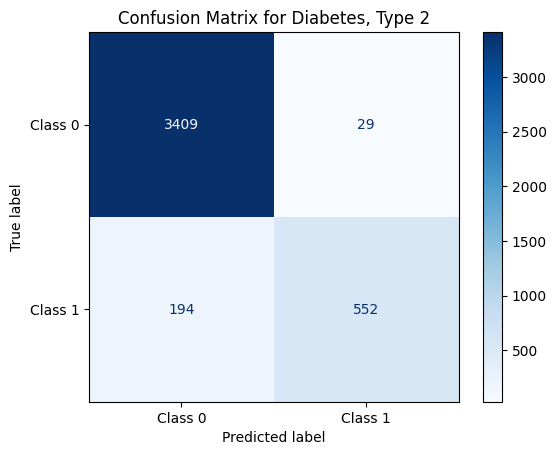


Confusion Matrix for High Blood Pressure:
[[3443   34]
 [ 235  472]]


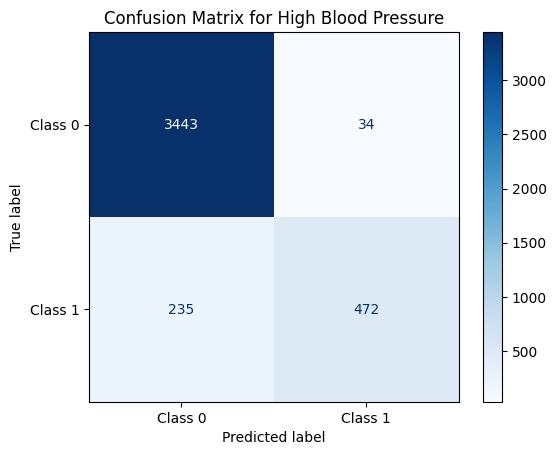

In [64]:
print("\nConfusion Matrices:")
for i, target in enumerate(['Depression', 'Diabetes, Type 2', 'High Blood Pressure']):
    print(f"\nConfusion Matrix for {target}:")
    cm = confusion_matrix(Y_test[target].values, Y_pred[:, i])
    print(cm)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Class 0", "Class 1"])
    disp.plot(cmap='Blues')
    plt.title(f"Confusion Matrix for {target}")
    plt.show()

# Bagging Classifier

In [65]:
model = MultiOutputClassifier(BaggingClassifier(DecisionTreeClassifier(), n_estimators=100, random_state=42))
model.fit(X_train,Y_train)

MultiOutputClassifier(estimator=BaggingClassifier(estimator=DecisionTreeClassifier(),
                                                  n_estimators=100,
                                                  random_state=42))

In [66]:
Y_pred = model.predict(X_test)
BC=accuracy_score(Y_test,Y_pred)*100
print("Accuracy Score ",BC)

Accuracy Score  85.25334608030593


In [67]:
print(classification_report(Y_test,Y_pred))

              precision    recall  f1-score   support

           0       0.92      0.94      0.93      2731
           1       0.89      0.76      0.82       746
           2       0.94      0.66      0.77       707

   micro avg       0.92      0.86      0.89      4184
   macro avg       0.92      0.79      0.84      4184
weighted avg       0.92      0.86      0.88      4184
 samples avg       0.86      0.86      0.86      4184



# Confusion Matrix


Confusion Matrices:

Confusion Matrix for Depression:
[[1223  230]
 [ 168 2563]]


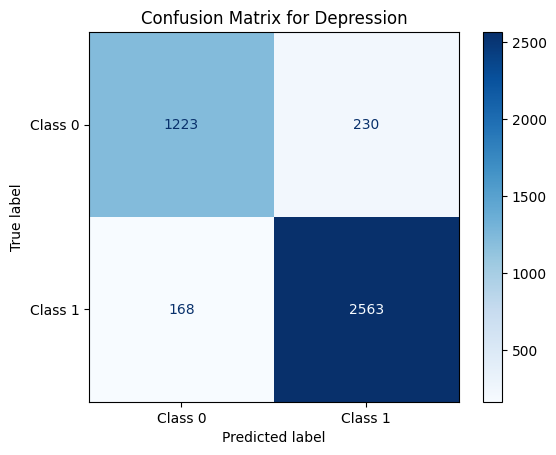


Confusion Matrix for Diabetes, Type 2:
[[3371   67]
 [ 180  566]]


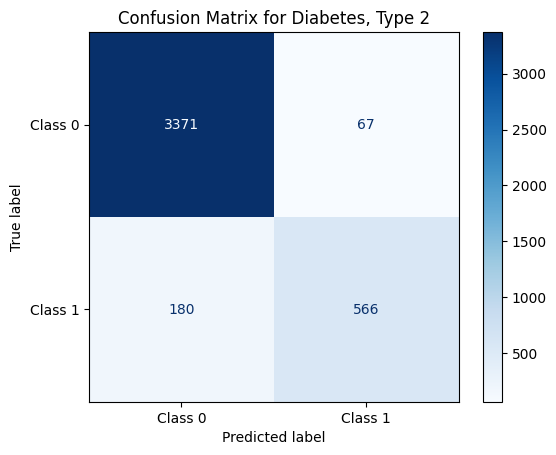


Confusion Matrix for High Blood Pressure:
[[3445   32]
 [ 240  467]]


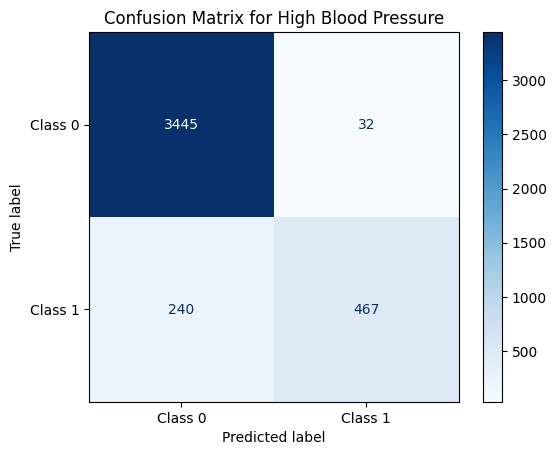

In [68]:
print("\nConfusion Matrices:")
for i, target in enumerate(['Depression', 'Diabetes, Type 2', 'High Blood Pressure']):
    print(f"\nConfusion Matrix for {target}:")
    cm = confusion_matrix(Y_test[target].values, Y_pred[:, i])
    print(cm)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Class 0", "Class 1"])
    disp.plot(cmap='Blues')
    plt.title(f"Confusion Matrix for {target}")
    plt.show()

# AdaBoost Classifier

In [69]:
model = MultiOutputClassifier(AdaBoostClassifier(n_estimators=100, random_state=36))
model.fit(X_train, Y_train)


MultiOutputClassifier(estimator=AdaBoostClassifier(n_estimators=100,
                                                   random_state=36))

In [70]:
Y_pred = model.predict(X_test)
AC=accuracy_score(Y_test,Y_pred)*100
print("Accuracy Score ",AC)

Accuracy Score  78.58508604206502


In [71]:
print(classification_report(Y_test, Y_pred))

              precision    recall  f1-score   support

           0       0.88      0.91      0.89      2731
           1       0.81      0.62      0.70       746
           2       0.83      0.61      0.70       707

   micro avg       0.86      0.81      0.83      4184
   macro avg       0.84      0.71      0.77      4184
weighted avg       0.86      0.81      0.83      4184
 samples avg       0.80      0.81      0.80      4184



# Confusion Matrix


Confusion Matrices:

Confusion Matrix for Depression:
[[1118  335]
 [ 248 2483]]


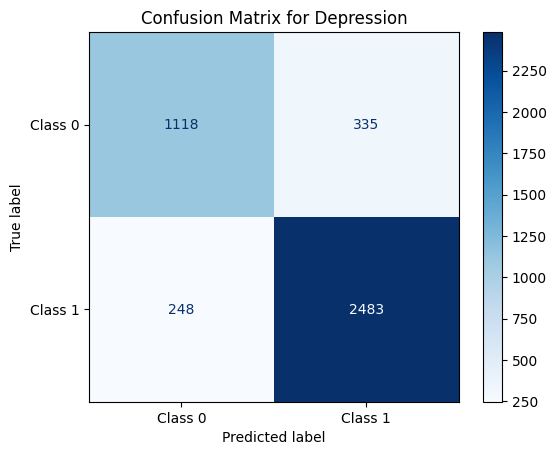


Confusion Matrix for Diabetes, Type 2:
[[3326  112]
 [ 283  463]]


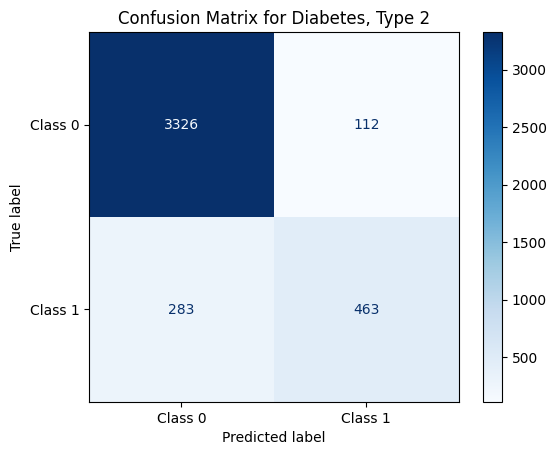


Confusion Matrix for High Blood Pressure:
[[3390   87]
 [ 279  428]]


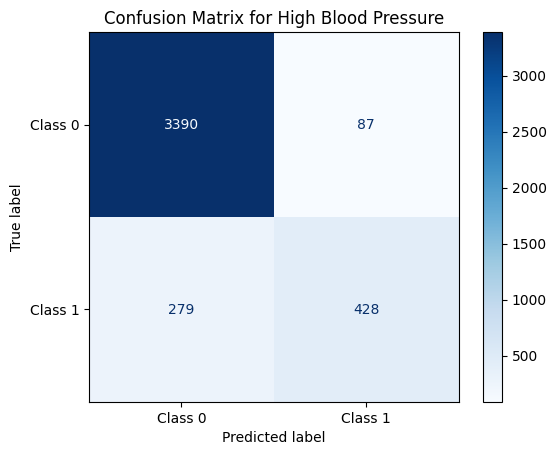

In [72]:
print("\nConfusion Matrices:")
for i, target in enumerate(['Depression', 'Diabetes, Type 2', 'High Blood Pressure']):
    print(f"\nConfusion Matrix for {target}:")
    cm = confusion_matrix(Y_test[target].values, Y_pred[:, i])
    print(cm)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Class 0", "Class 1"])
    disp.plot(cmap='Blues')
    plt.title(f"Confusion Matrix for {target}")
    plt.show()

# KNN

In [73]:
knn_model = KNeighborsClassifier(n_neighbors=5)
knn_model.fit(X_train,Y_train)

KNeighborsClassifier()

In [74]:
Y_pred=knn_model.predict(X_test)
KNN=accuracy_score(Y_test,Y_pred)*100
print("Accuracy Score ",KNN)

Accuracy Score  75.16730401529637


In [75]:
print(classification_report(Y_test,Y_pred))

              precision    recall  f1-score   support

           0       0.86      0.86      0.86      2731
           1       0.70      0.54      0.61       746
           2       0.75      0.56      0.64       707

   micro avg       0.82      0.75      0.78      4184
   macro avg       0.77      0.65      0.70      4184
weighted avg       0.81      0.75      0.78      4184
 samples avg       0.75      0.75      0.75      4184



# Confusion Matrix


Confusion Matrices:

Confusion Matrix for Depression:
[[1066  387]
 [ 390 2341]]


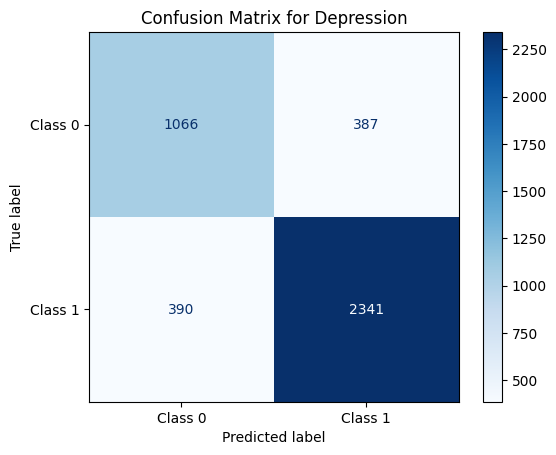


Confusion Matrix for Diabetes, Type 2:
[[3263  175]
 [ 341  405]]


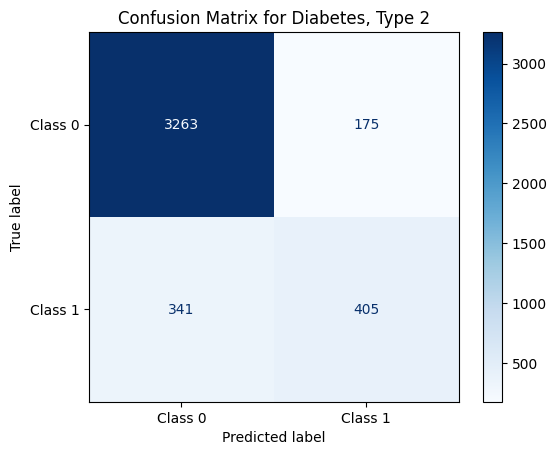


Confusion Matrix for High Blood Pressure:
[[3342  135]
 [ 308  399]]


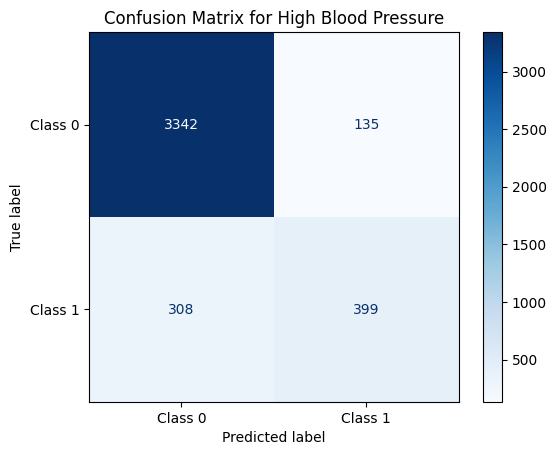

In [76]:
print("\nConfusion Matrices:")
for i, target in enumerate(['Depression', 'Diabetes, Type 2', 'High Blood Pressure']):
    print(f"\nConfusion Matrix for {target}:")
    cm = confusion_matrix(Y_test[target].values, Y_pred[:, i])
    print(cm)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Class 0", "Class 1"])
    disp.plot(cmap='Blues')
    plt.title(f"Confusion Matrix for {target}")
    plt.show()

# SVM

In [77]:
from sklearn import svm
from sklearn.svm import SVC

In [78]:
clf=MultiOutputClassifier(SVC())
clf.fit(X_train , Y_train)
Y_pred = clf.predict(X_test)
SVM=accuracy_score(Y_test,Y_pred)*100
print("Accuracy Score ",SVM)

Accuracy Score  80.92734225621415


In [79]:
print(classification_report(Y_test,Y_pred))

              precision    recall  f1-score   support

           0       0.90      0.93      0.92      2731
           1       0.91      0.61      0.73       746
           2       0.93      0.56      0.70       707

   micro avg       0.90      0.81      0.86      4184
   macro avg       0.91      0.70      0.78      4184
weighted avg       0.91      0.81      0.85      4184
 samples avg       0.81      0.81      0.81      4184



# Confusion Matrix


Confusion Matrices:

Confusion Matrix for Depression:
[[1164  289]
 [ 184 2547]]


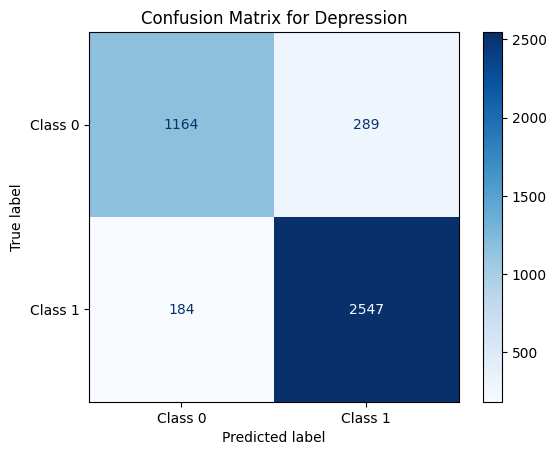


Confusion Matrix for Diabetes, Type 2:
[[3394   44]
 [ 288  458]]


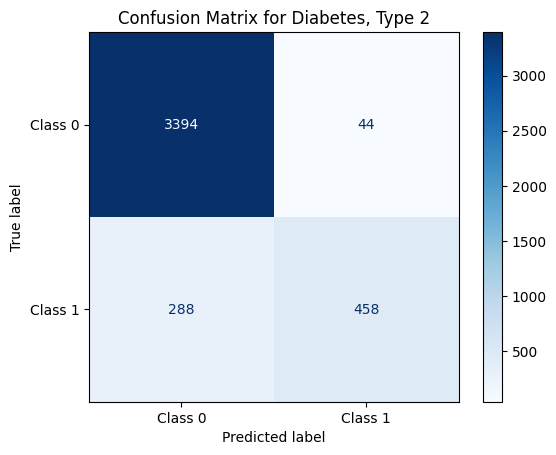


Confusion Matrix for High Blood Pressure:
[[3449   28]
 [ 309  398]]


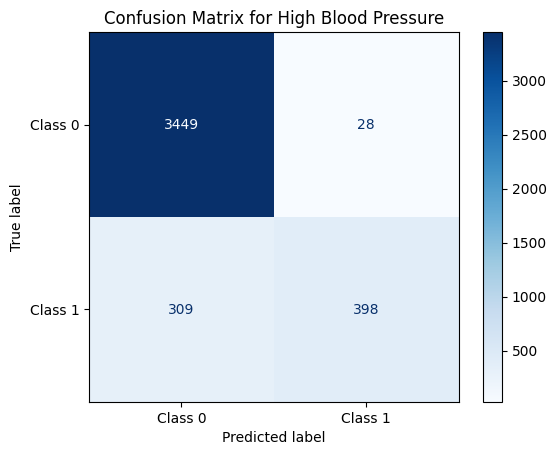

In [80]:
print("\nConfusion Matrices:")
for i, target in enumerate(['Depression', 'Diabetes, Type 2', 'High Blood Pressure']):
    print(f"\nConfusion Matrix for {target}:")
    cm = confusion_matrix(Y_test[target].values, Y_pred[:, i])
    print(cm)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Class 0", "Class 1"])
    disp.plot(cmap='Blues')
    plt.title(f"Confusion Matrix for {target}")
    plt.show()

# LGBM

In [81]:
model=MultiOutputClassifier(LGBMClassifier())
model.fit(X_train,Y_train)

[LightGBM] [Info] Number of positive: 6338, number of negative: 3422
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.013885 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 23213
[LightGBM] [Info] Number of data points in the train set: 9760, number of used features: 92
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.649385 -> initscore=0.616338
[LightGBM] [Info] Start training from score 0.616338
[LightGBM] [Info] Number of positive: 1808, number of negative: 7952
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.013317 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 23213
[LightGBM] [Info] Number of data points in the train set: 9760, number of used features: 92
[LightGBM] [Info] [binar

MultiOutputClassifier(estimator=LGBMClassifier())

In [82]:
Y_pred=model.predict(X_test)
LGBM=accuracy_score(Y_test,Y_pred)*100
print("Accuracy Score ",LGBM)

Accuracy Score  83.26959847036329


In [83]:
print(classification_report(Y_test,Y_pred))

              precision    recall  f1-score   support

           0       0.92      0.93      0.92      2731
           1       0.88      0.70      0.78       746
           2       0.90      0.65      0.76       707

   micro avg       0.91      0.84      0.87      4184
   macro avg       0.90      0.76      0.82      4184
weighted avg       0.91      0.84      0.87      4184
 samples avg       0.84      0.84      0.84      4184



# Confusion Matrix


Confusion Matrices:

Confusion Matrix for Depression:
[[1233  220]
 [ 196 2535]]


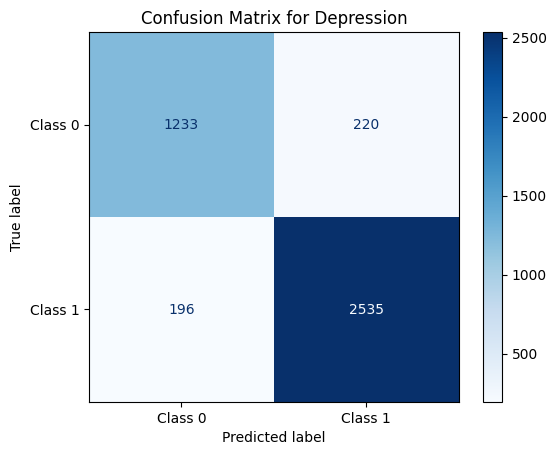


Confusion Matrix for Diabetes, Type 2:
[[3363   75]
 [ 221  525]]


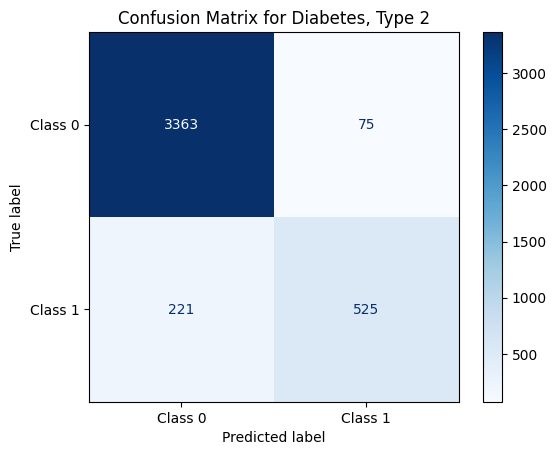


Confusion Matrix for High Blood Pressure:
[[3424   53]
 [ 244  463]]


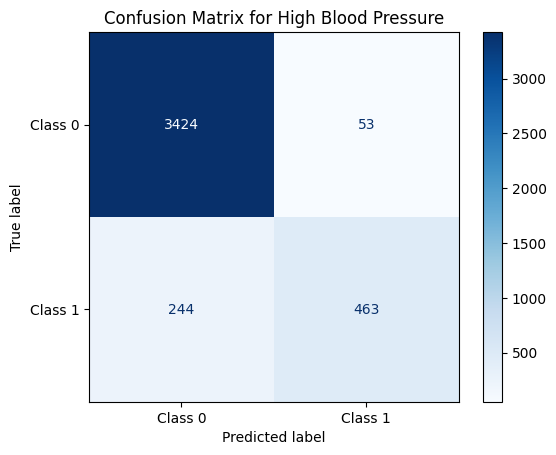

In [84]:
print("\nConfusion Matrices:")
for i, target in enumerate(['Depression', 'Diabetes, Type 2', 'High Blood Pressure']):
    print(f"\nConfusion Matrix for {target}:")
    cm = confusion_matrix(Y_test[target].values, Y_pred[:, i])
    print(cm)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Class 0", "Class 1"])
    disp.plot(cmap='Blues')
    plt.title(f"Confusion Matrix for {target}")
    plt.show()

# XGBM

In [85]:
model=XGBClassifier()
model.fit(X_train,Y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [86]:
Y_pred=model.predict(X_test)
XGBM=accuracy_score(Y_test,Y_pred)*100
print("Accuracy Score ",XGBM)


Accuracy Score  83.05449330783938


In [87]:
print(classification_report(Y_test,Y_pred))

              precision    recall  f1-score   support

           0       0.92      0.93      0.92      2731
           1       0.89      0.72      0.80       746
           2       0.89      0.65      0.75       707

   micro avg       0.91      0.84      0.88      4184
   macro avg       0.90      0.77      0.82      4184
weighted avg       0.91      0.84      0.87      4184
 samples avg       0.84      0.84      0.84      4184



# Confusion Matrix


Confusion Matrices:

Confusion Matrix for Depression:
[[1238  215]
 [ 201 2530]]


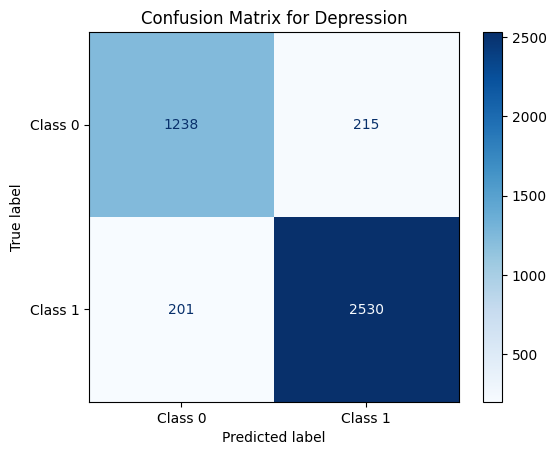


Confusion Matrix for Diabetes, Type 2:
[[3369   69]
 [ 208  538]]


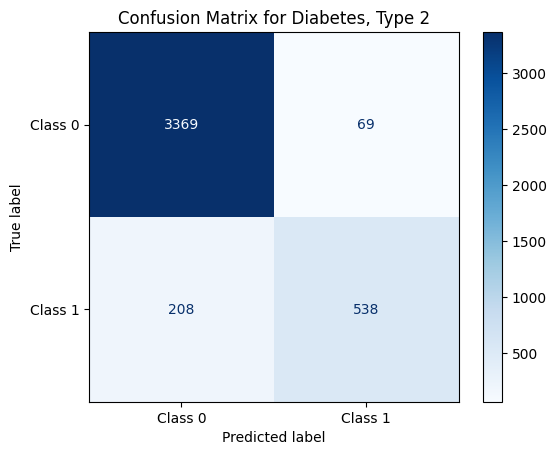


Confusion Matrix for High Blood Pressure:
[[3418   59]
 [ 249  458]]


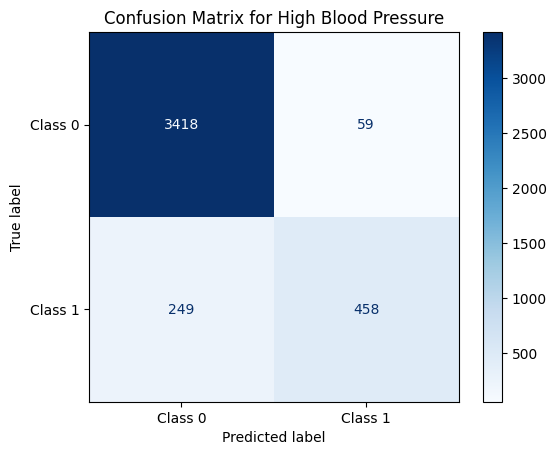

In [88]:
print("\nConfusion Matrices:")
for i, target in enumerate(['Depression', 'Diabetes, Type 2', 'High Blood Pressure']):
    print(f"\nConfusion Matrix for {target}:")
    cm = confusion_matrix(Y_test[target].values, Y_pred[:, i])
    print(cm)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Class 0", "Class 1"])
    disp.plot(cmap='Blues')
    plt.title(f"Confusion Matrix for {target}")
    plt.show()

# Selecting the Best Model using Accuracy

In [89]:
models=["Random Forest","Bagging Classifier","AdaBoost Classifier","KNN","SVM","LGBM","XGBM"]
accuracy_scores=[RF,BC,AC,KNN,SVM,LGBM,XGBM]
Best_Model=pd.DataFrame({"Models":models,"Accuracy Score":accuracy_scores})
Best_Model


,Models,Accuracy Score
0,Random Forest,86.782983
1,Bagging Classifier,85.253346
2,AdaBoost Classifier,78.585086
3,KNN,75.167304
4,SVM,80.927342
5,LGBM,83.269598
6,XGBM,83.054493


We are getting good accuracy for Random Forest Model.So we are considering it.

In [90]:
import pickle


with open('vectorizer.pkl', 'wb') as vec_file:
    pickle.dump(vectorizer, vec_file)


with open('rf_model.pkl', 'wb') as model_file:
    pickle.dump(rf_model, model_file)